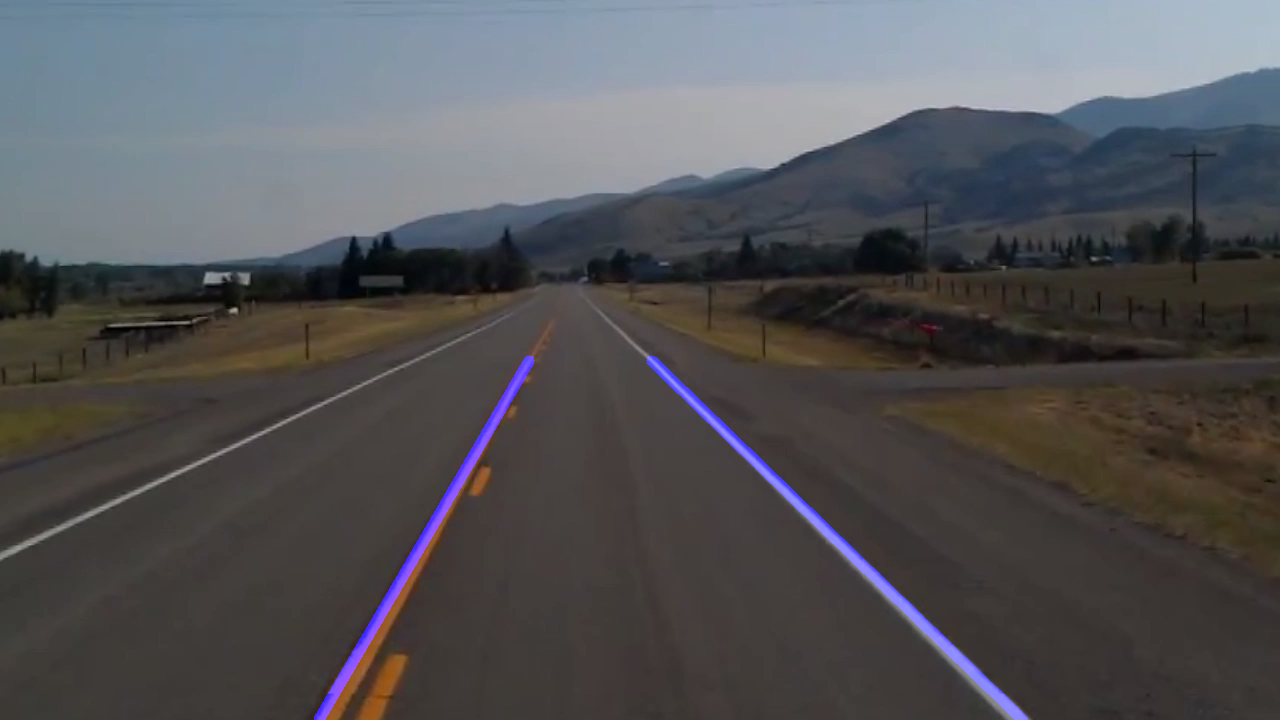

In [ ]:
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
 
def canny(img):
  #Turn image grayscale and do edge detection (5x5 Gaussian blur)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  kernel = 5
  blur = cv2.GaussianBlur(gray, (kernel, kernel), 0)
  canny = cv2.Canny(gray, 50, 150) #Type of edge detection we're doing
  return canny

def region_of_interest(canny):
  #Define area of the image we want to consider (ie. lane we're in)
  height = canny.shape[0]
  width = canny.shape[1]
  #Create array the size of video, with all values 0 (ie. all black)
  mask = np.zeros_like(canny)
  triangle = np.array([[(200, height), (550, 250), (1100, height),]], np.int32)
  #Fill mask with triangle shape
  cv2.fillPoly(mask, triangle, 255)
  masked_image = cv2.bitwise_and(canny, mask)
  return masked_image

def houghLines(cropped_canny):
  return cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

def addWeighted(frame, line_image):
  return cv2.addWeighted(frame, 0.8, line_image, 1, 1)
 
def display_lines(img, lines):
  #Overlay lines on video image (ie. make a new mask)
  line_image = np.zeros_like(img)
  if lines is not None:
    for line in lines:
      for x1, y1, x2, y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
  return line_image

def make_points(image, line):
  slope, intercept = line
  y1 = int(image.shape[0]) #Bottom of image
  y2 = int(y1*0.5) #Slightly lower than middle
  x1 = int((y1-intercept)/slope)
  x2 = int((y2-intercept)/slope)
  return [[x1, y1, x2, y2]]
 
def average_slope_intercept(image, lines):
  left_fit = []
  right_fit = []
  if lines is None:
    return None
  
  for line in lines:
    for x1, y1, x2, y2 in line:
      #Return slope & intercept
      fit = np.polyfit((x1,x2), (y1,y2), 1)
      slope = fit[0]
      intercept = fit[1]
      #If slope is negative, then its left lane boundary. Else right
      if slope <= 0:
        left_fit.append((slope, intercept))
      else:
        right_fit.append((slope, intercept))
  #Error handling - if program can't find data, add a placeholder
  if not left_fit:
    left_fit.append((-1, 0))
  if not right_fit:
    right_fit.append((1, 0))

  left_average = np.average(left_fit, axis=0)
  right_average = np.average(right_fit, axis=0)

  left_line = make_points(image, left_average)
  right_line = make_points(image, right_average)
  averaged_lines =[left_line, right_line]
  return averaged_lines

#Main Program
cap = cv2.VideoCapture("test2.mp4")
frame_array = []
while(cap.isOpened()):
  _, frame = cap.read()
  if frame is None:
    break
  canny_image = canny(frame)
  cropped_canny = region_of_interest(canny_image)
  lines = houghLines(cropped_canny)
  averaged_lines = average_slope_intercept(frame, lines)
  line_image = display_lines(frame, averaged_lines)
  combo_image = addWeighted(frame, line_image)
  frame_array.append(combo_image)
cap.release()

cv2_imshow(frame_array[0])

In [ ]:
img_arr = []
for i in frame_array:
  img_arr.append(Image.fromarray(cv2.cvtColor(i, cv2.COLOR_BGR2RGB)))

img_arr[0].save("yay.gif", save_all=True, append_images=img_arr[1:1000], optimize=False)